### 

# Rapport Technique : Partie 1



Le but de ce test est de développer un modèle prédictif pour estimer les primes commerciales des concurrents à partir d'un ensemble de données 

# Importation des Bibliothèques 


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Any, Tuple
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve
from common_function import(
          load_config ,
          load_data,
          detect_missing_values ,
          save_model_with_directory,
          plot_box_plot,
          plot_feature_distribution,
          plot_correlation_matrix,
          plot_scatter,
          detect_outliers_summary,
          cap_outliers,
          log_transform,
          scale_features,
          preprocess_modeling,
          evaluation_metrics,
          evaluate_on_validation_set,
          
)
import joblib
import os

## Étape 1 : Préparation des données

Charger et comprendre les données brutes afin de déterminer la qualité des données et les caractéristiques de chaque variable

### 1.Chargement de la Configuration et des Données

In [70]:
""" Charger le fichier de configuration pour accéder aux chemins d'accès et aux paramètres, 
puis  l'utiliser pour charger les données d'entraînement
"""
config = load_config("config\config.yaml") 
data=load_data(config['data']['train_path'])
test_data=load_data(config['data']['test_path'])

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PolicyId           22481 non-null  object 
 1   AgeConducteur      22481 non-null  float64
 2   SexeConducteur     22481 non-null  object 
 3   StatutMatrimonial  7372 non-null   object 
 4   BonusMalus         22481 non-null  float64
 5   FrequencePaiement  22481 non-null  object 
 6   CodeProfession     7372 non-null   object 
 7   AgeVehicule        22481 non-null  float64
 8   ClasseVehicule     22481 non-null  object 
 9   PuissanceVehicule  22481 non-null  object 
 10  CarburantVehicule  22481 non-null  object 
 11  UsageVehicule      22481 non-null  object 
 12  Garage             22481 non-null  object 
 13  Region             22481 non-null  object 
 14  PrimeCommerciale   22481 non-null  float64
dtypes: float64(4), object(11)
memory usage: 2.6+ MB


Les données comportent des **variables numériques** (***AgeConducteur***, ***BonusMalus***, ***AgeVehicule***, ***PrimeCommerciale***) et **des variables catégorielles** (SexeConducteur, FrequencePaiement, ClasseVehicule, etc.).


***PolicyId*** est un identifiant unique en format texte et ne sera pas utilisée pour l’entraînement.


### 2. Exploration et Nettoyage des donnés

Identifier et gérer les valeurs manquantes, les incohérences et les outliers.

In [131]:
data.head(10) # Afficher les 10 premières lignes du dataset

PolicyId  AgeConducteur SexeConducteur StatutMatrimonial  BonusMalus  \
0  90144365.100b           40.0              M               NaN        50.0   
1  90194873.100a           46.0              M               NaN        50.0   
2  90134157.100a           37.0              M               NaN        50.0   
3  90109178.102a           51.0              M        Cohabiting        50.0   
4  90170847.100a           29.0              M               NaN        80.0   
5  90134602.100c           50.0              F               NaN        50.0   
6  90187000.100a           23.0              F               NaN        95.0   
7  90157757.100b           41.0              M               NaN        57.0   
8  90108260.101a           49.0              M        Cohabiting        50.0   
9  90154521.100c           32.0              F               NaN        72.0   

  FrequencePaiement    CodeProfession  AgeVehicule ClasseVehicule  \
0       Half-yearly               NaN          6.0        Cheaper   
1            Annual               NaN          2.0          Cheap   
2       Half-yearly               NaN         10.0        Cheaper   
3            Annual  Private employee          5.0       Cheapest   
4            Annual               NaN         10.0          Cheap   
5            Annual               NaN          8.0       Cheapest   
6       Half-yearly               NaN          9.0       Cheapest   
7            Annual               NaN          1.0     Medium low   
8       Half-yearly           Retiree          0.0        Cheaper   
9            Annual               NaN          8.0       Cheapest   

  PuissanceVehicule CarburantVehicule           UsageVehicule  \
0               P12            Diesel  Private+trip to office   
1               P12            Diesel            Professional   
2               P10            Diesel  Private+trip to office   
3                P7           Regular  Private+trip to office   
4               P13           Regular  Private+trip to office   
5                P9           Regular  Private+trip to office   
6                P9           Regular  Private+trip to office   
7               P13           Regular  Private+trip to office   
8               P12            Diesel  Private+trip to office   
9                P9           Regular  Private+trip to office   

                      Garage        Region  PrimeCommerciale  
0                Closed zbox    South West             350.0  
1                Closed zbox  Headquarters             529.2  
2                Closed zbox        Center             145.3  
3                Closed zbox        Center             213.6  
4  Closed collective parking        Center             296.2  
5  Opened collective parking    Paris area             184.7  
6  Opened collective parking        Center             513.6  
7  Closed collective parking    Paris area             765.8  
8                Closed zbox        Center             371.2  
9                     Street        Center             259.3

In [132]:
data.shape

(22481, 15)

In [3]:
detect_missing_values(data)

Column  Missing Values
0  StatutMatrimonial           15109
1     CodeProfession           15109

**StatutMatrimonial** et **CodeProfession** ont un nombre important de valeurs manquantes, avec seulement 7372 valeurs renseignées sur 22481. 
La gestion des valeurs manquantes sera donc cruciale ici pour ne pas biaiser le modèle.

**NB**: il est préférable d'imputer les valeurs manquantes plutôt que de supprimer ces lignes, car cela entraînerait une perte d'environ 67% des données.

In [4]:
print("les valeurs de StatutMatrimonial:",data['StatutMatrimonial'].unique())
print("les valeurs de CodeProfession :",data['CodeProfession'].unique())

les valeurs de StatutMatrimonial: [nan 'Cohabiting' 'Married' 'Single' 'Widowed' 'Divorced']
les valeurs de CodeProfession : [nan 'Private employee' 'Retiree' 'Public employee' 'Other' 'Farmer'
 'Craftsman' 'Retailer']


**Options de gestion** :
* **Imputation par le mode** : Remplir les valeurs manquantes avec la valeur la plus courante, si l’une des catégories est très représentée.
* **Catégorie "Non spécifé"** : cette option permettrait de prendre en compte l'absence de cette information est significative, ce qui pourrait être pertinent.



**NB** : certains clients ne souhaitent pas déclarer leur statut

Donc Je vais remplir les valeurs manquantes par la valeur "Non spécifé"

In [52]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pré-traite les données en remplissant les valeurs manquantes pour certaines colonnes spécifiques.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les données à pré-traiter.

    Returns:
        pd.DataFrame: Le DataFrame avec les valeurs manquantes remplies pour les colonnes 'StatutMatrimonial' et 'CodeProfession'.

    Étapes de pré-traitement :
        - Remplit les valeurs manquantes dans las colonne 'StatutMatrimonial'et 'CodeProfession' avec "Non spécifé".
    """
    
    df['StatutMatrimonial'].fillna("Non spécifié", inplace=True)
    df['CodeProfession'].fillna("Non spécifié", inplace=True)
    return df

In [4]:
preprocess_data=preprocess_data(data) # Data with new vlaues
preprocess_data.head()

PolicyId  AgeConducteur SexeConducteur StatutMatrimonial  BonusMalus  \
0  90144365.100b           40.0              M      Non spécifié        50.0   
1  90194873.100a           46.0              M      Non spécifié        50.0   
2  90134157.100a           37.0              M      Non spécifié        50.0   
3  90109178.102a           51.0              M        Cohabiting        50.0   
4  90170847.100a           29.0              M      Non spécifié        80.0   

  FrequencePaiement    CodeProfession  AgeVehicule ClasseVehicule  \
0       Half-yearly      Non spécifié          6.0        Cheaper   
1            Annual      Non spécifié          2.0          Cheap   
2       Half-yearly      Non spécifié         10.0        Cheaper   
3            Annual  Private employee          5.0       Cheapest   
4            Annual      Non spécifié         10.0          Cheap   

  PuissanceVehicule CarburantVehicule           UsageVehicule  \
0               P12            Diesel  Private+trip to office   
1               P12            Diesel            Professional   
2               P10            Diesel  Private+trip to office   
3                P7           Regular  Private+trip to office   
4               P13           Regular  Private+trip to office   

                      Garage        Region  PrimeCommerciale  
0                Closed zbox    South West             350.0  
1                Closed zbox  Headquarters             529.2  
2                Closed zbox        Center             145.3  
3                Closed zbox        Center             213.6  
4  Closed collective parking        Center             296.2

### 3. Analyse exploratoire des données (EDA)

Obtenir une vue d’ensemble des statistiques de base pour chaque variable afin de déceler des patterns ou des anomalies dans les données.

Identifier les variables les plus influentes sur PrimeCommerciale et de visualiser les relations entre les variables .

* **3.1 Analyse statistique descriptive**


In [7]:
data.describe()

AgeConducteur    BonusMalus   AgeVehicule  PrimeCommerciale
count   22481.000000  22481.000000  22481.000000      22481.000000
mean       39.719185     63.242471      7.505805        420.786077
std        11.854692     15.381818      4.848366        219.261080
min        18.000000     50.000000      0.000000         91.000000
25%        31.000000     50.000000      4.000000        264.800000
50%        37.000000     57.000000      7.000000        375.100000
75%        47.000000     72.000000     10.000000        521.300000
max        87.000000    156.000000     89.000000       2902.300000


**AgeConducteur**

* **Moyenne**: 39.7 ans, avec un écart-type de 11.85 ans.
* **Distribution**  : L’âge des conducteurs varie de 18 à 87 ans. Les percentiles indiquent que 50 % des conducteurs ont moins de 37 ans, et 75 % ont moins de 47 ans.

* **Analyse** : La majorité des conducteurs sont dans un intervalle d'âge moyenne, ce qui est cohérent avec la démographie de nombreux assurés mais Les valeurs extrêmes, comme 87 ans, pourraient influencer la prime .

**BonusMalus**

* **Moyenne** : 63.24, avec un écart-type de 15.38.

* **Distribution** : La valeur minimale de BonusMalus est de 50, indiquant des conducteurs sans accidents récents. La valeur maximale de 156 peut correspondre à des conducteurs avec un historique de sinistres.

* **Analyse** : Cette variable a une signification directe sur le calcul de la prime. Un BonusMalus plus élevé peut être synonyme de primes plus coûteuses. La distribution montre que 75 % des assurés ont un BonusMalus inférieur à 72, ce qui suggère que la majorité des conducteurs ont un bon historique.



**AgeVehicule (Âge du véhicule)**

* **Moyenne** : 7.5 ans, avec un écart-type de 4.84 ans.
* **Distribution** : L’âge du véhicule varie de 0 (véhicules neufs) à 89 ans. Les quartiles indiquent que 50 % des véhicules ont moins de 7 ans, et 75 % moins de 10 ans.

* **Analyse** : La distribution est relativement concentrée autour de la moyenne, mais quelques véhicules très anciens peuvent nécessiter une attention particulière dans l'analyse, car ils pourraient influencer le modèle.



**PrimeCommerciale (Variable cible)**

* **Moyenne** : 420.79 , avec un écart-type de 219.26 
* **Distribution** : Les primes vont de 91  à 2902.3 . La médiane est de 375.1 €, ce qui signifie que la moitié des assurés paient moins de cette valeur.

* **Analyse** : La large gamme de primes reflète des variations importantes en fonction des caractéristiques des conducteurs et des véhicules. La queue de distribution des primes élevée (jusqu'à 2902 €) indique quelques valeurs extrêmes qui pourraient affecter la performance du modèle si elles sont mal gérées.



***Conclusion et Implications***

* **Normalisation** : Les variables AgeConducteur, BonusMalus, et AgeVehicule présentent des échelles différentes, il est donc pertinent de normaliser ou standardiser ces variables pour garantir une meilleure convergence des modèles linéaires.

* **Outliers** : Les valeurs extrêmes de AgeVehicule et PrimeCommerciale nécessiteront une attention particulière. 



* **2.2 Visualisation des distributions et relations**

In [5]:
Numerical_colomuns=config['features']['numerical']
Categorical_columns=config['features']['categorical']

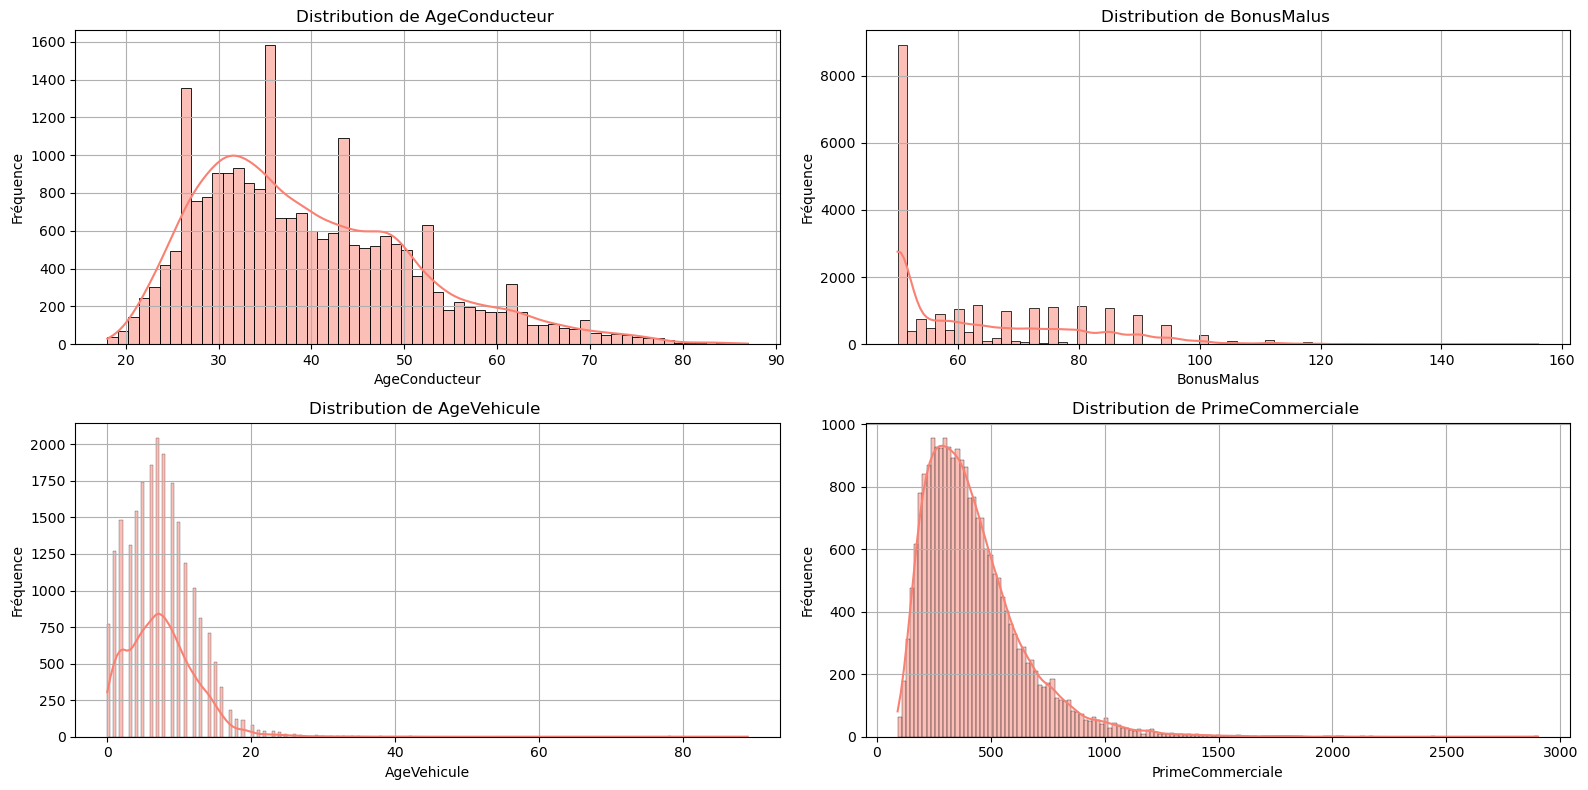

In [7]:
plt.figure(figsize=(16, 8))
sns.color_palette("coolwarm")
for i, col in enumerate(Numerical_colomuns, 1):
          plt.subplot(2, 2, i)
          plt.grid(True)       
          plot_feature_distribution(preprocess_data,col)
plt.tight_layout()
plt.show()

**AgeConducteur** : La distribution de l’âge des conducteurs est légèrement asymétrique

**BonusMalus** : La distribution de BonusMalus est très asymétrique, 

**AgeVehicule** : La majorité des véhicules ont un âge inférieur à 10 ans . Les véhicules plus anciens sont rares, mais ils pourraient entraîner des primes plus élevées en raison d'un risque accru lié à l’usure.

**PrimeCommerciale** : La distribution de PrimeCommerciale  est fortement asymétrique, avec une majorité des primes situées entre 100 et 700 €. Il y a quelques valeurs élevées (au-delà de 2000 €), qui représentent des outliers potentiels. Cette distribution montre que la majorité des primes sont faibles, avec quelques valeurs extrêmes qui nécessiteront une attention particulière.

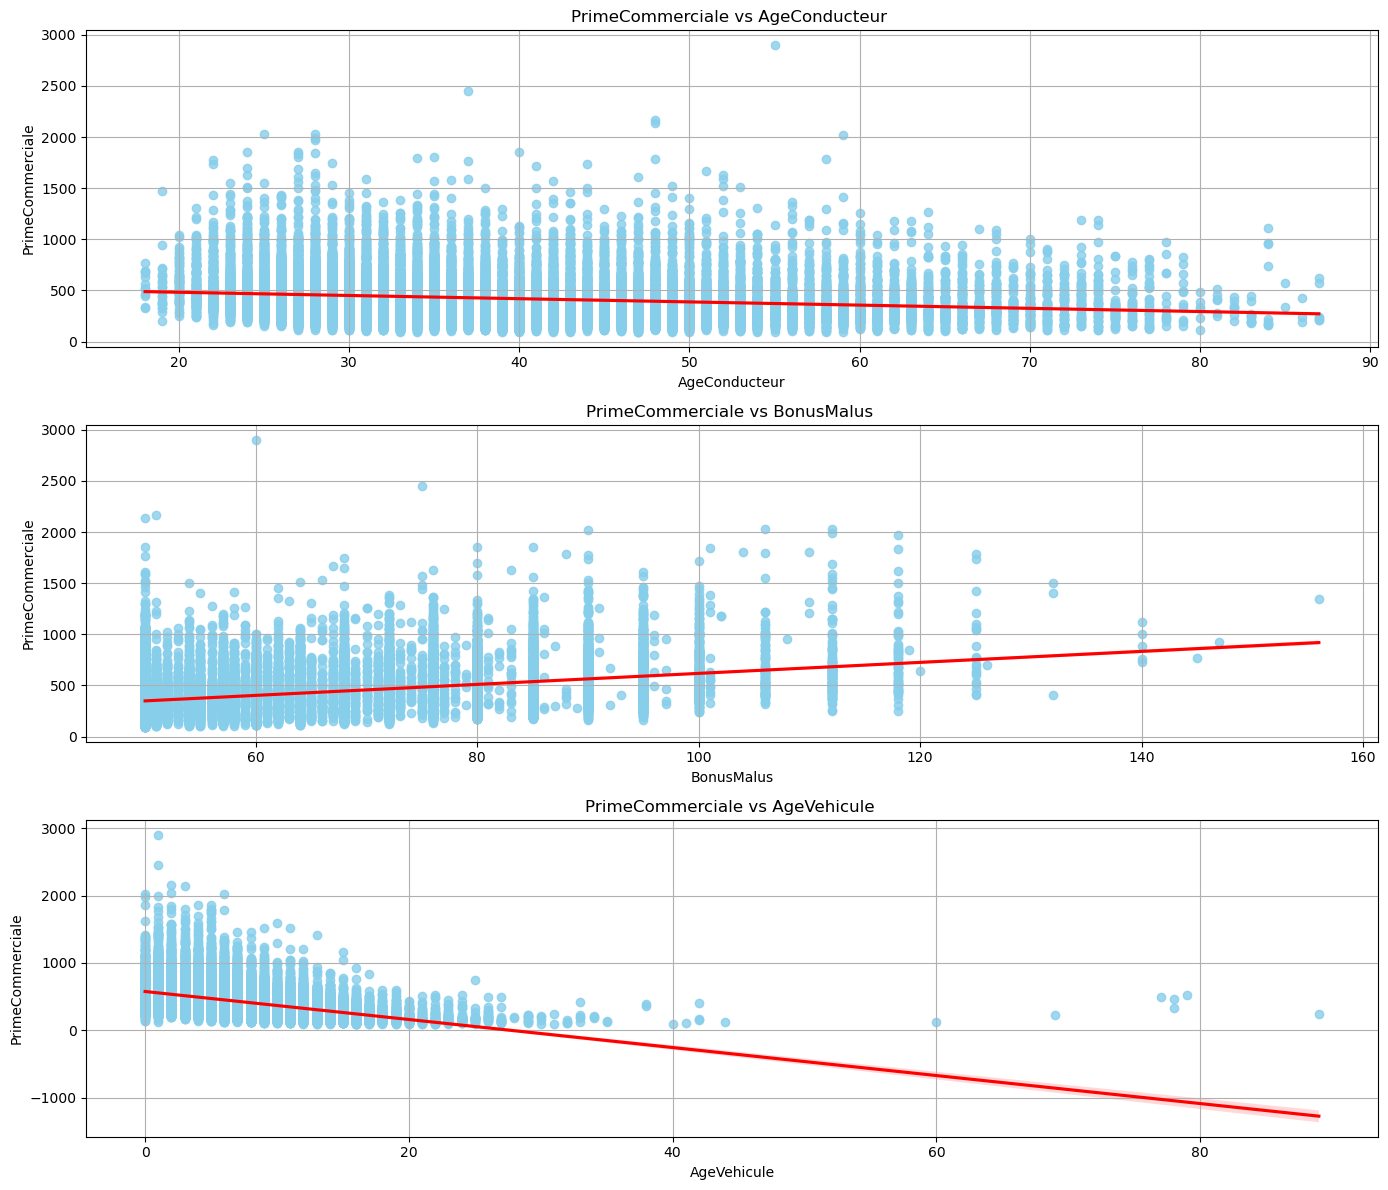

In [140]:
plt.figure(figsize=(14,12))
sns.color_palette("dark")
target='PrimeCommerciale'
for i, col in enumerate(Numerical_colomuns[:-1],1):
          plt.subplot(3,1,i)
          plot_scatter(preprocess_data,col,target)
plt.tight_layout()
plt.show()

**PrimeCommerciale VS AgeConducteur** :

* La ligne de tendance montre que PrimeCommerciale diminue légèrement avec l'augmentation de l'âge du conducteur.


* AgeConducteur dans le modèle est pertinent pour capter la variation de la prime selon les catégories d'âge.

**PrimeCommerciale vs BonusMalus** :

* Le graphique montre une tendance positive, où une augmentation du BonusMalus entraîne une hausse de la prime. 

* Cette relation renforce le choix d’inclure BonusMalus comme variable prédictive clé, car elle influence directement les ajustements de prime.


**PrimeCommerciale vs AgeVehicule** :

* Le graphique de dispersion montre que les primes diminuent avec l'âge du véhicule, illustrant la relation inverse entre la valeur du véhicule et son âge.

* AgeVehicule doit être conservé dans le modèle, car il permet de prendre en compte le risque financier pour l'assureur en fonction de l'âge et de la valeur du véhicule.

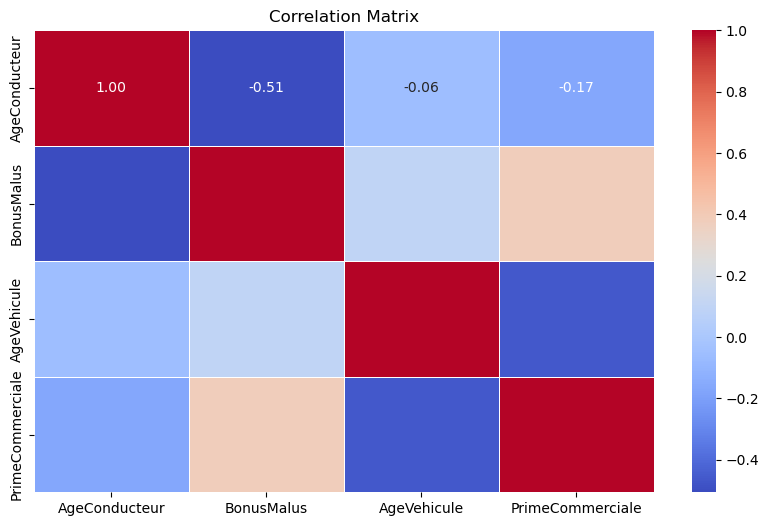

In [127]:
plt.figure(figsize=(10,6))
df_corr= preprocess_data[Numerical_colomuns]
plot_correlation_matrix(df_corr)


* La corrélation modérée de 0.38 entre BonusMalus et PrimeCommerciale montre que plus le BonusMalus est élevé, plus la prime d'assurance (PrimeCommerciale) augmente. 


* Une corrélation de -0.46 est observée entre AgeVehicule et PrimeCommerciale. Cette relation négative suggère que les véhicules plus anciens ont des primes d’assurance plus faibles

* La corrélation de -0.17 entre AgeConducteur et PrimeCommerciale est relativement faible, mais elle montre une légère tendance de réduction de la prime avec l'âge. Les conducteurs plus jeunes paient souvent des primes plus élevées, car ils sont considérés comme plus risqués.


**Conslusion**

* Les corrélations et les graphiques de dispersion démontre une compréhension claire des relations entre les variables et PrimeCommerciale. Les analyses montrent comment chaque variable influence la prime, ce qui est essentiel pour une modélisation efficace.

* En sélectionnant BonusMalus, AgeVehicule, et AgeConducteur, nous capturons les facteurs de risque liés au comportement du conducteur, à la valeur du véhicule et à l’expérience du conducteur. Ces choix sont en cohérence avec les pratiques d’assurance et les standards de l’industrie.

* Ces variables devraient contribuer de manière significative à la précision du modèle, car elles couvrent différents aspects du risque (comportement, valeur du véhicule, et profil d'âge). L’inclusion de ces variables est donc prévue pour optimiser la performance prédictive de PrimeCommerciale.

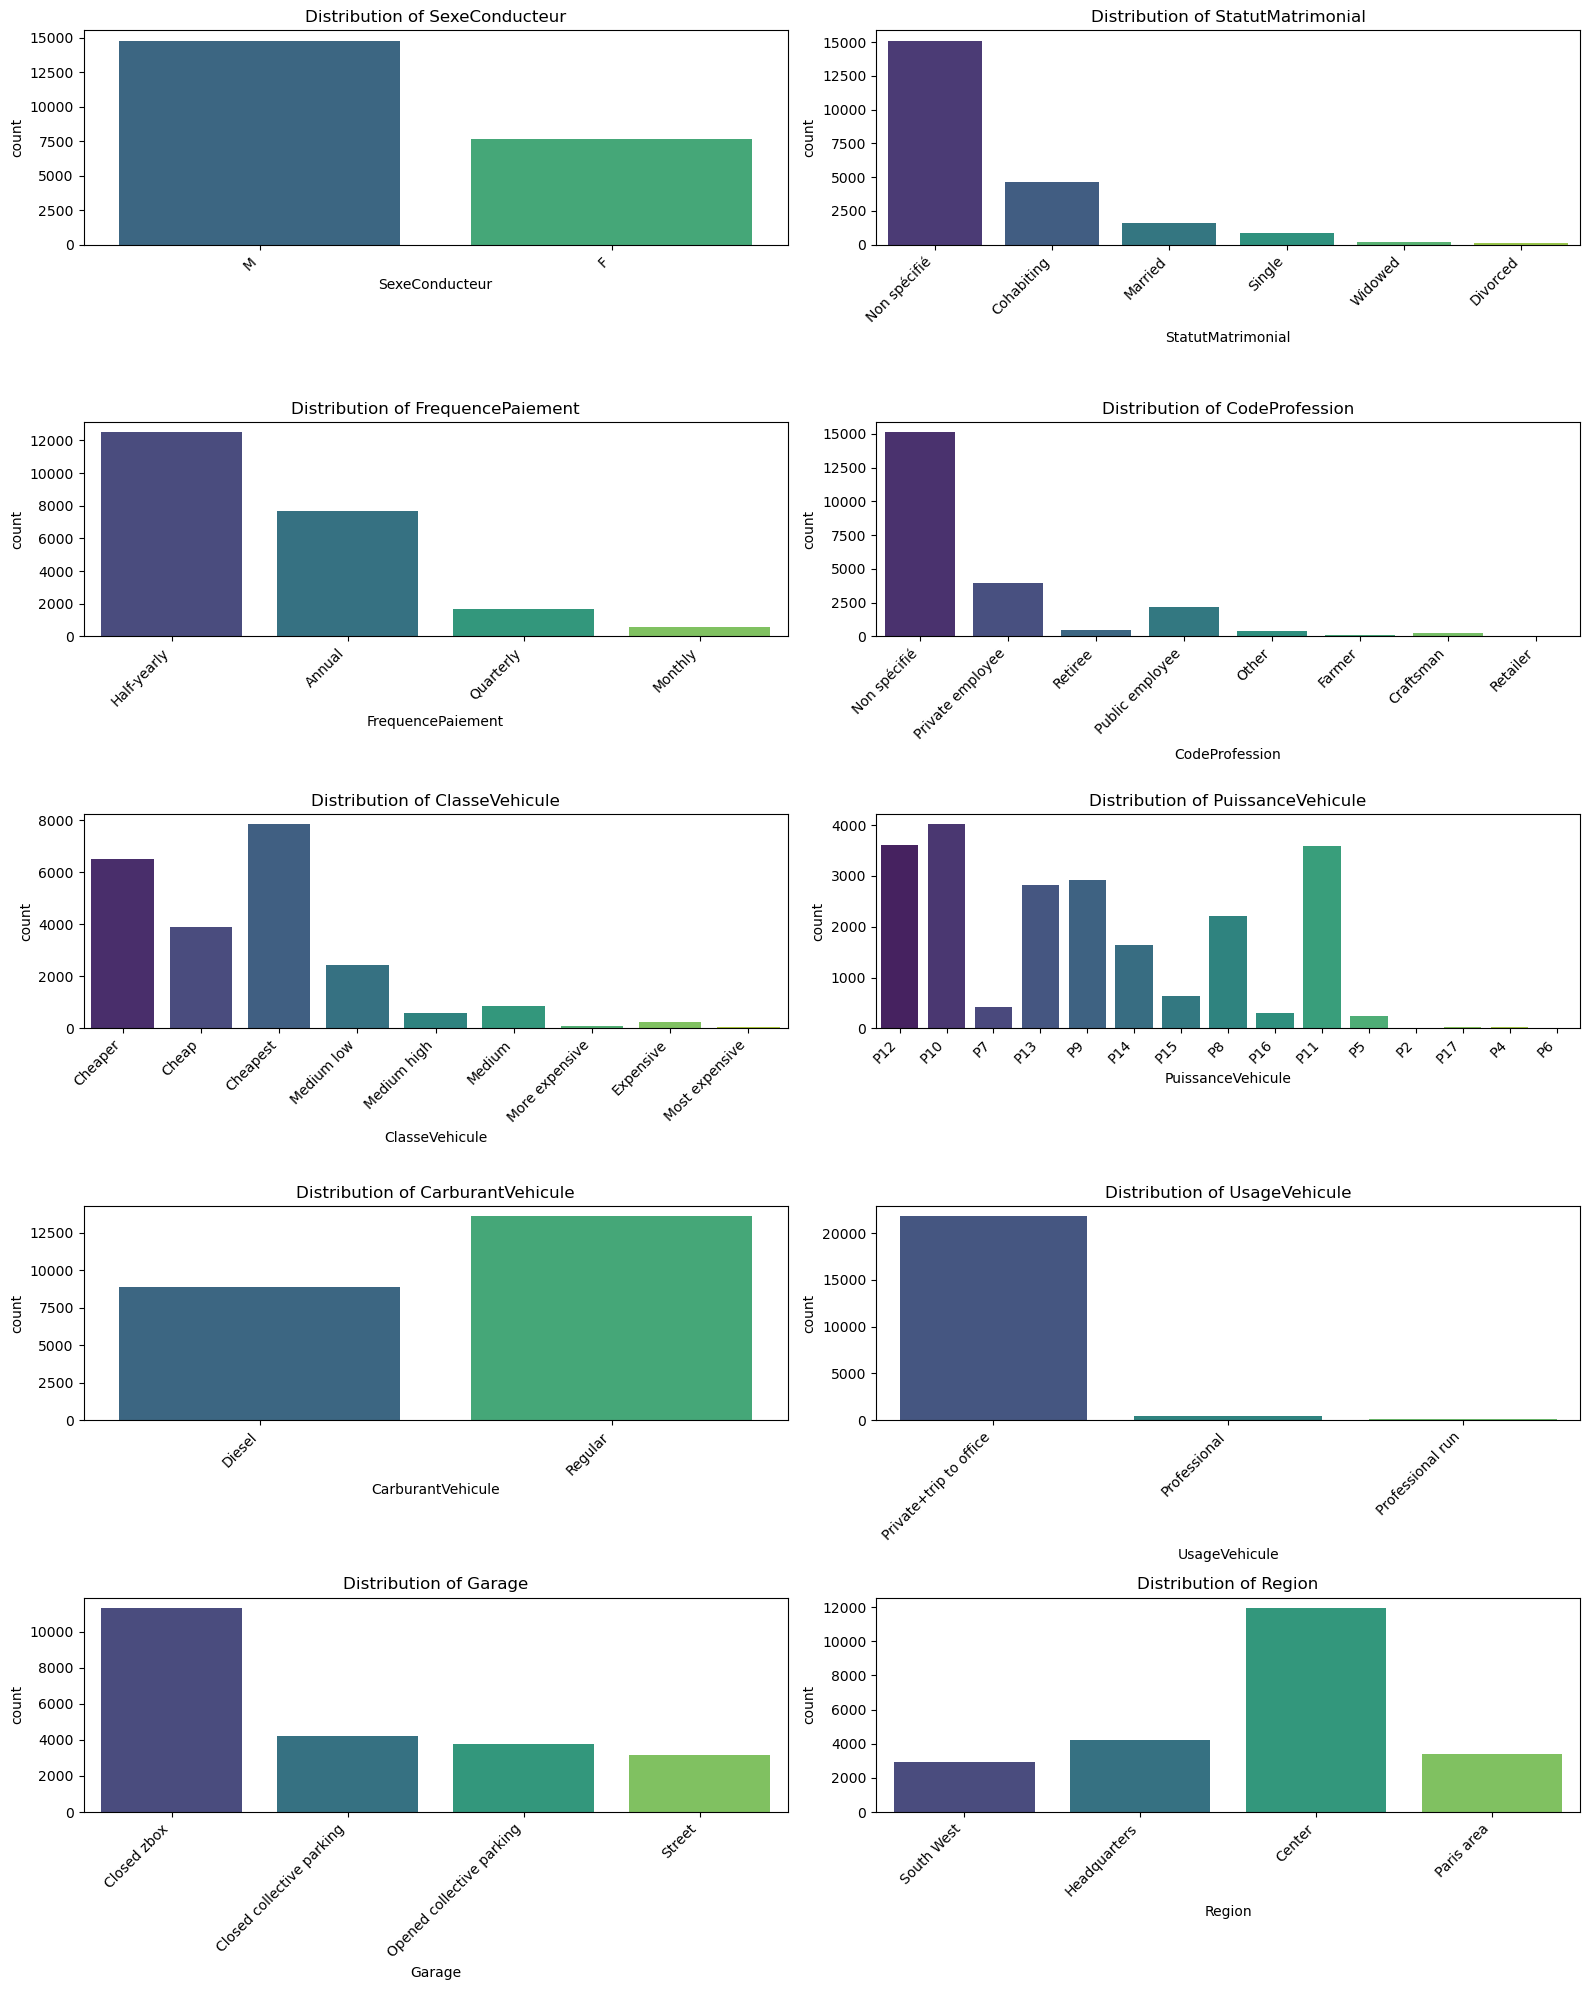

In [142]:
plt.figure(figsize=(16, 20))
for i, column in enumerate(Categorical_columns, 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=data, x=column, palette="viridis")
    plt.title(f"Distribution of {column}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.show()

**Encodage One-Hot** et **Traitement des Valeurs "Non spécifié"** : L'encodage one-hot des catégories dominantes permet de minimiser le biais dans le modèle, et le traitement des valeurs "Non spécifié" comme catégorie .

En intégrant des termes d’interaction entre des variables, on capture des relations complexes qui peuvent mieux expliquer la variabilité des primes.


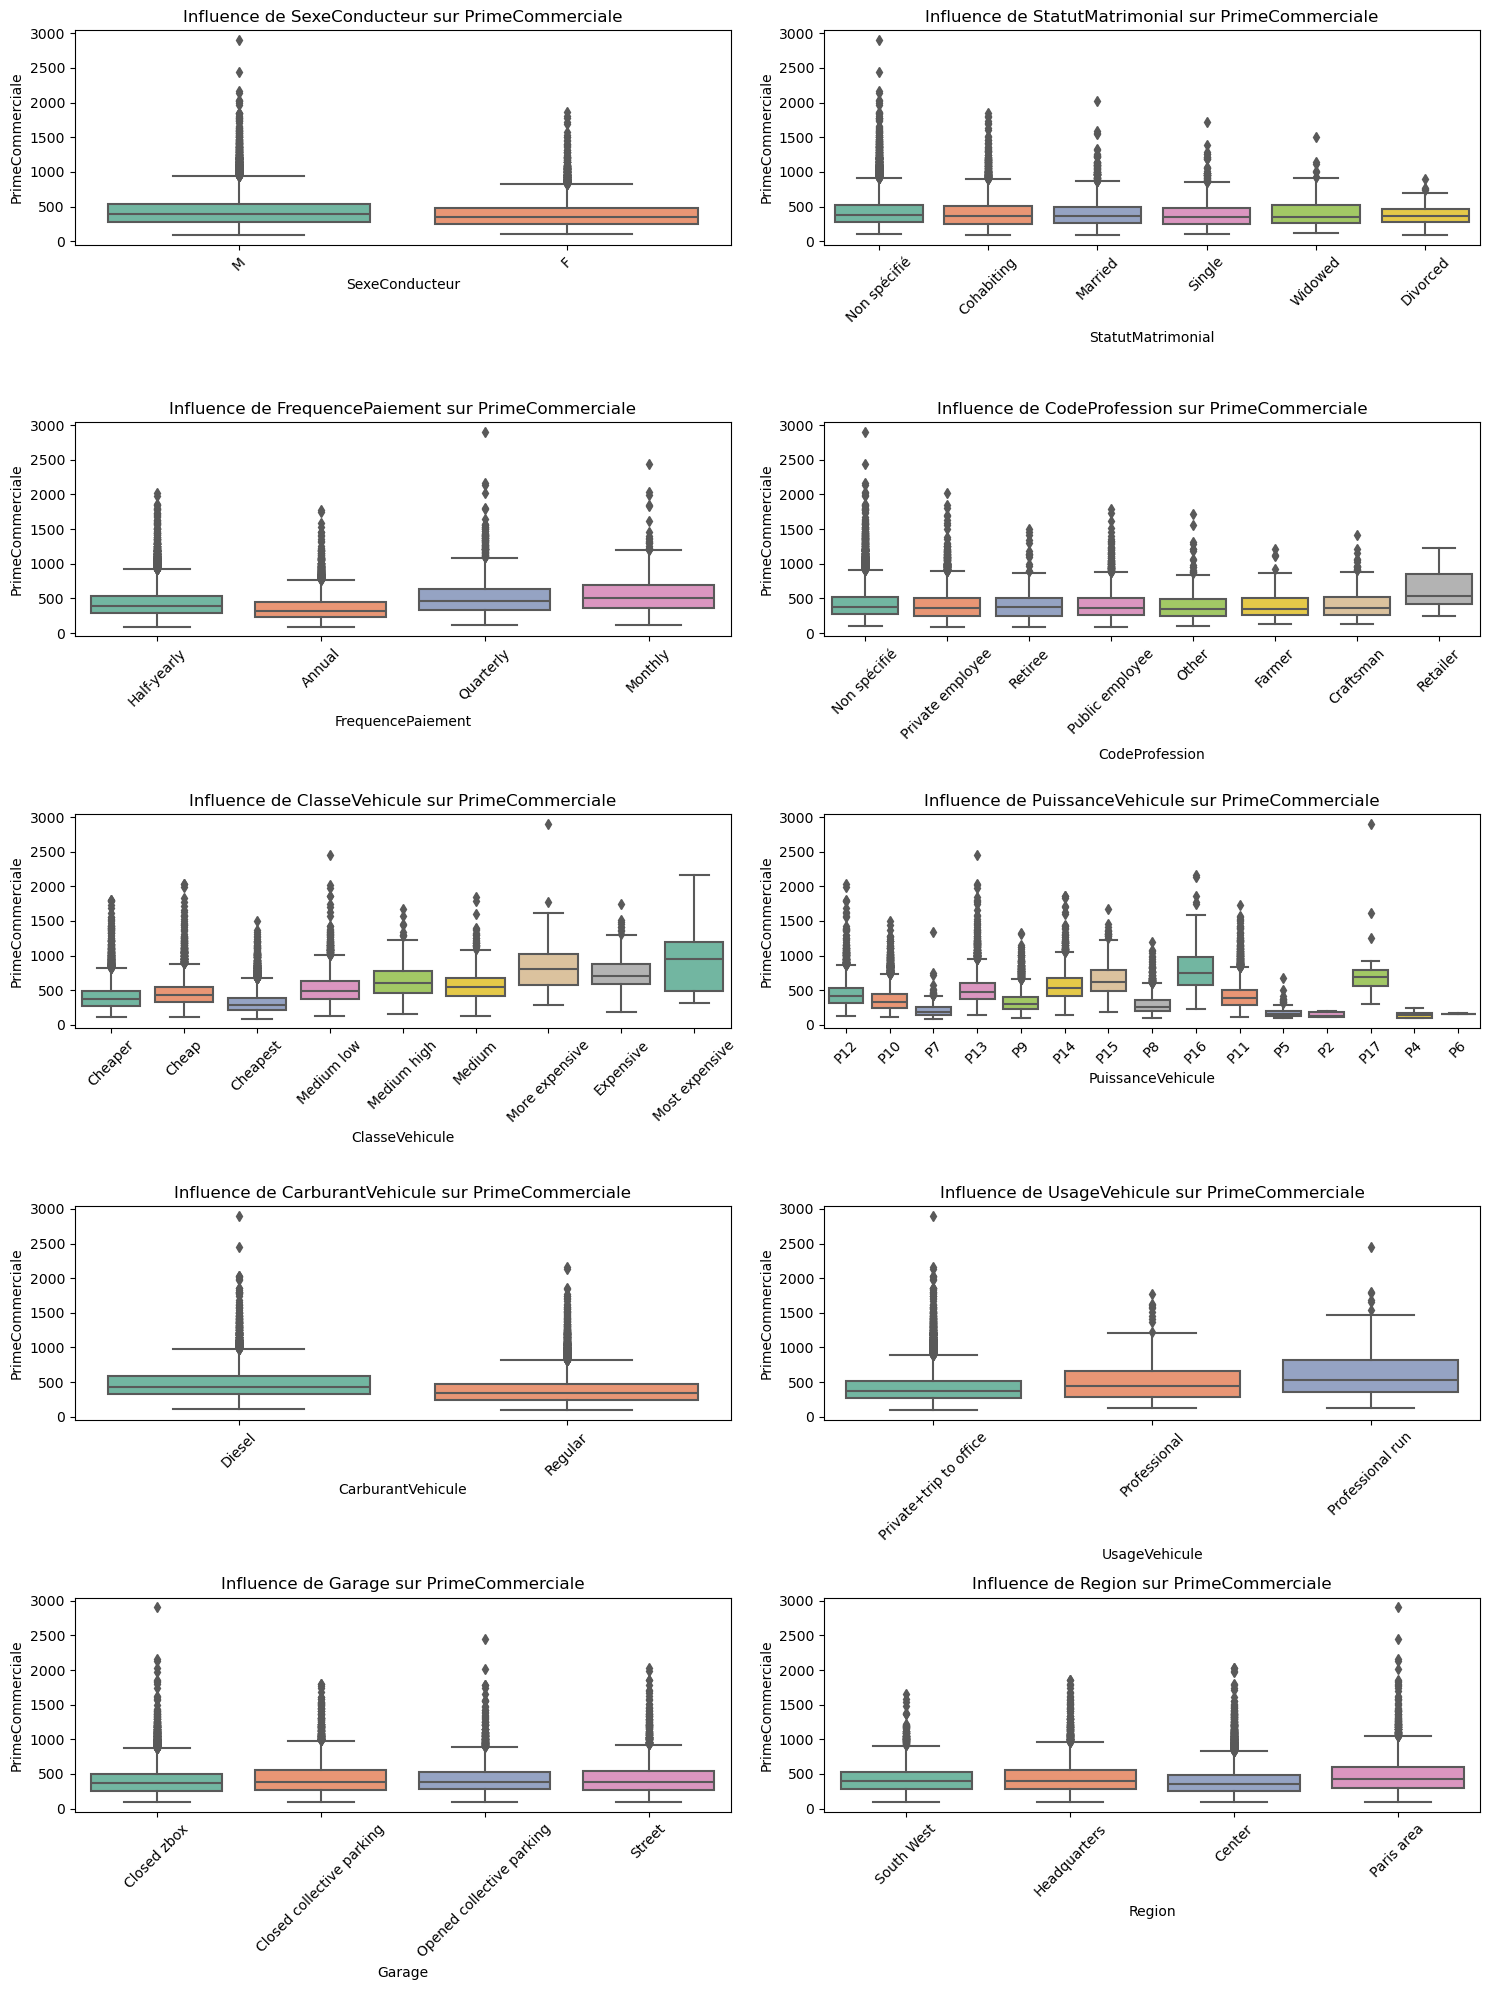

In [143]:
plt.figure(figsize=(15, 20))
# Plotting box plots for each continuous variable to visualize outliers
for i, col in enumerate(Categorical_columns, 1):
    plt.subplot(len(Categorical_columns)//2, 2, i)
    plot_box_plot(preprocess_data ,col,'PrimeCommerciale')

plt.tight_layout()
plt.show()

Les graphiques montrent que les primes d’assurance sont influencées par plusieurs facteurs. Les femmes, les veufs/divorcés, et les professions comme agriculteur ou commerçant paient généralement des primes plus élevées. Les véhicules plus puissants, chers, ou utilisés à des fins professionnelles, ainsi que ceux garés dans la rue ou situés dans certaines régions, augmentent également le coût. Les paiements mensuels sont les plus onéreux. Ces variables clés sont essentielles pour affiner la prédiction des primes.

### 4. Détection des Outliers


identifier les valeurs extrêmes qui peuvent fausser les résultats de la modélisation prédictive

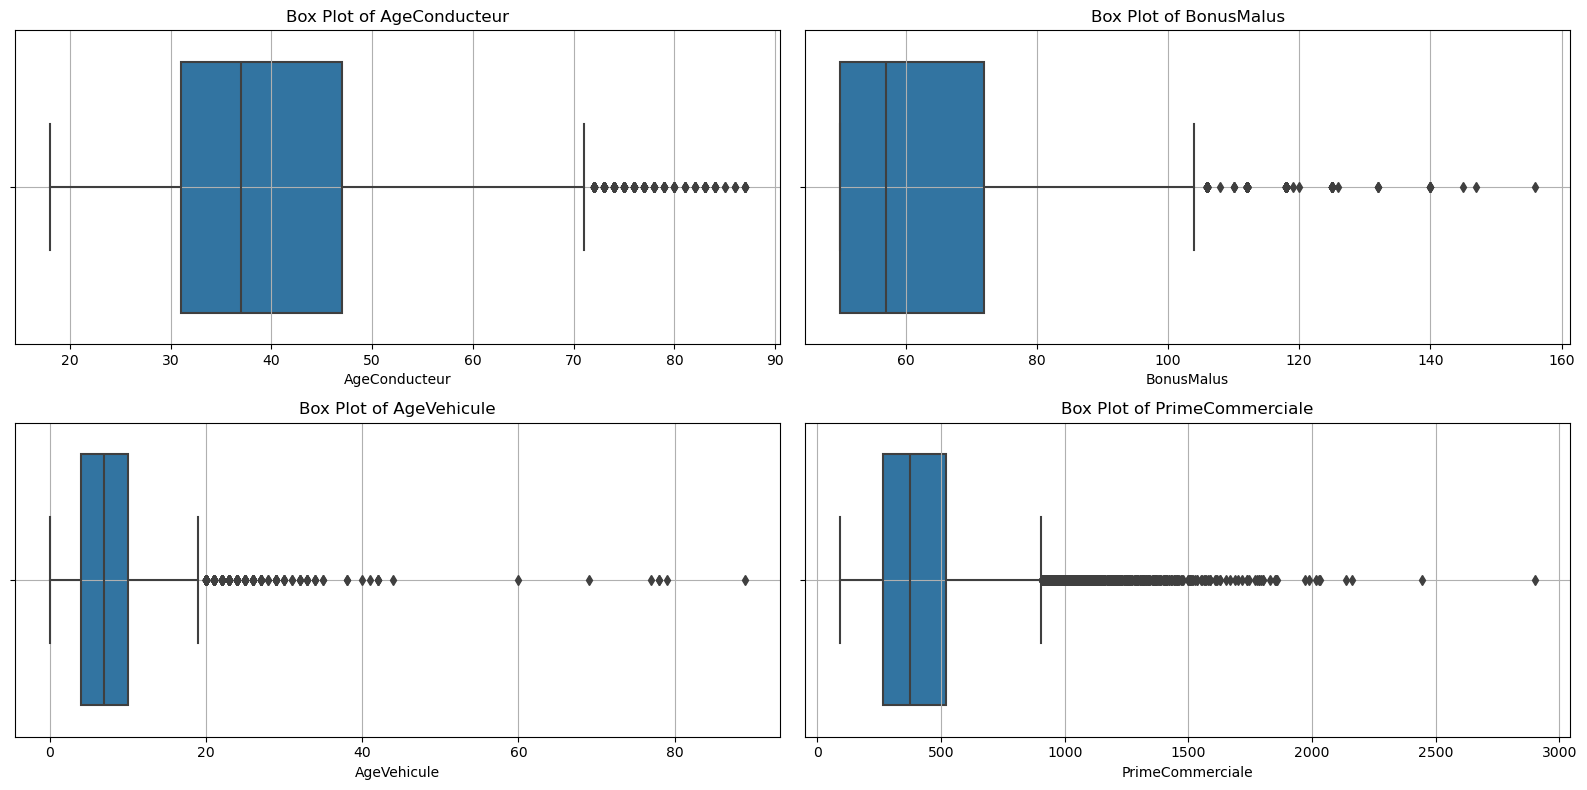

In [ ]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(Numerical_colomuns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=preprocess_data[col])
    plt.title(f'Box Plot of {col}')
    plt.grid(True)

plt.tight_layout()
plt.show()

En appliquant les méthodes de détection d’outliers sur les colonnes numériques, voici le nombre d'outliers détectés pour chaque variable 

In [129]:
detect_outliers_summary(preprocess_data,Numerical_colomuns)

{'AgeConducteur': 329,
 'BonusMalus': 312,
 'AgeVehicule': 327,
 'PrimeCommerciale': 775}

Les box-plots et les résultats de détection des outliers montrent un nombre significatif de valeurs aberrantes dans les différentes variables, en particulier pour la variable cible PrimeCommerciale. 



**Actions**  :

* **Capping des valeurs extrêmes** : Limiter les valeurs extrêmes à des seuils raisonnables pour PrimeCommerciale, BonusMalus, et AgeVehicule afin de réduire leur impact disproportionné sur le modèle.

* **Transformation Logarithmique** : Appliquer une transformation logarithmique à pour stabiliser l’effet des valeurs extrêmes tout en préservant les relations d'ordre.

In [6]:
train_data=preprocess_data.copy()
columns_do_capping = config['features']['capping']
scaled_columns = config['features']['scaled']
for col in columns_do_capping:
    train_data = cap_outliers(train_data, col) #Limite les valeurs extrêmes pour stabiliser les distributions.
train_data=log_transform(train_data,Numerical_colomuns) #Limite les valeurs extrêmes pour stabiliser les distributions
#train_data=scale_features(train_data,scaled_columns)
train_data.drop(columns=Numerical_colomuns, inplace=True) #Garde uniquement les versions transformées des colonnes.
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PolicyId              22481 non-null  object 
 1   SexeConducteur        22481 non-null  object 
 2   StatutMatrimonial     22481 non-null  object 
 3   FrequencePaiement     22481 non-null  object 
 4   CodeProfession        22481 non-null  object 
 5   ClasseVehicule        22481 non-null  object 
 6   PuissanceVehicule     22481 non-null  object 
 7   CarburantVehicule     22481 non-null  object 
 8   UsageVehicule         22481 non-null  object 
 9   Garage                22481 non-null  object 
 10  Region                22481 non-null  object 
 11  AgeConducteur_log     22481 non-null  float64
 12  BonusMalus_log        22481 non-null  float64
 13  AgeVehicule_log       22481 non-null  float64
 14  PrimeCommerciale_log  22481 non-null  float64
dtypes: float64(4), obje

In [131]:
train_data.describe()

AgeConducteur_log  BonusMalus_log  AgeVehicule_log  \
count       22481.000000    22481.000000     22481.000000   
mean            3.666502        4.135985         1.947059   
std             0.281538        0.217997         0.674035   
min             2.944439        3.931826         0.000000   
25%             3.465736        3.931826         1.609438   
50%             3.637586        4.060443         2.079442   
75%             3.871201        4.290459         2.397895   
max             4.477337        4.663439         2.995732   

       PrimeCommerciale_log  
count          22481.000000  
mean               5.918227  
std                0.472941  
min                4.521789  
25%                5.582744  
50%                5.929855  
75%                6.258242  
max                6.810198

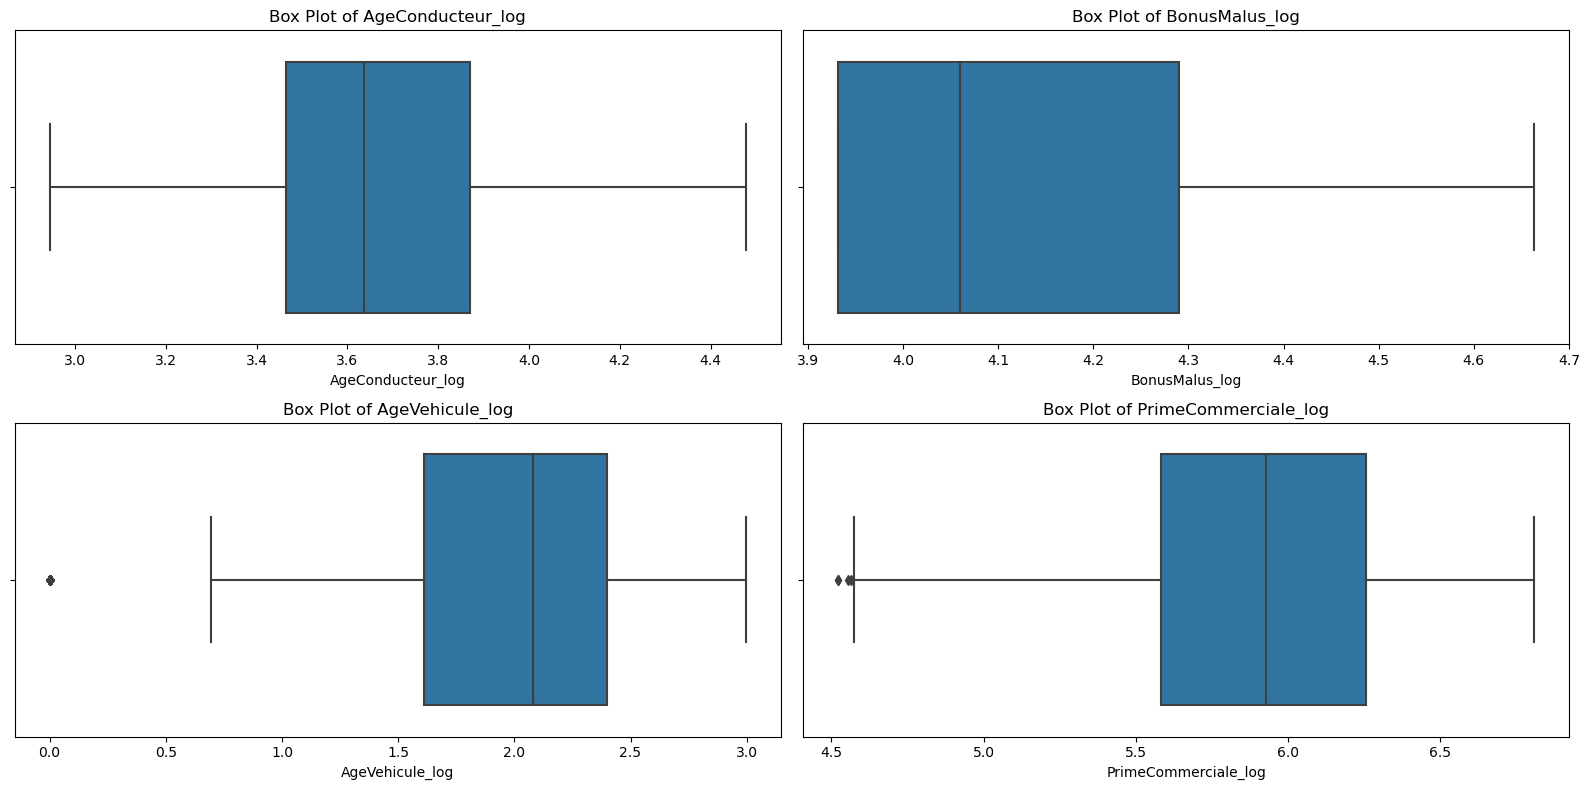

In [132]:
plt.figure(figsize=(16, 8))

# Plotting box plots for each continuous variable to visualize outliers
for i, col in enumerate(scaled_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()

L'application du capping et de la transformation logarithmique a permis de :

Réduire l'impact des valeurs extrêmes dans chaque variable, en rendant les distributions plus symétriques et plus homogènes.
Améliorer la stabilité des variables pour la modélisation, en s’assurant que les valeurs aberrantes n’influencent pas de manière disproportionnée les prédictions.

## 5.Feature-engineering

* On commence par créer une interaction entre l’âge du conducteur et l’âge du véhicule, ce qui permet d’explorer l’effet combiné de ces deux variables.
* Ensuite, on simplifie l’analyse de l’âge du conducteur en le classant dans trois groupes : jeunes, matures et seniors.
* Une autre idée est d’ajouter une caractéristique qui mesure la différence entre le bonus-malus et l’âge du conducteur, pour détecter des tendances intéressantes.
* Pour exploiter les catégories d’âge, on les encode en valeurs numériques via un one-hot encoding.
* Enfin, on génère des variables polynomiales pour capturer des relations non linéaires entre certaines colonnes.

In [7]:
def add_interaction_feature(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute une caractéristique d'interaction entre l'âge du conducteur et l'âge du véhicule.
    """
    df['Driver_Vehicle_Age_Interaction'] = df['AgeConducteur_log'] * df['AgeVehicule_log']
    return df

def bin_age_conducteur(df: pd.DataFrame) -> pd.DataFrame:
    """
    Effectue un binning de 'AgeConducteur_log' en trois catégories : 'Young', 'Mature' et 'Senior'.
    """
    df['AgeConducteur_Binned'] = pd.cut(
        df['AgeConducteur_log'],
        bins=[-np.inf, np.log1p(25), np.log1p(50), np.inf],
        labels=['Young', 'Mature', 'Senior']
    )
    return df

def create_bonus_age_difference(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crée une nouvelle caractéristique en soustrayant l'âge du conducteur du BonusMalus.
    """
    df['Bonus_Age_Difference'] = df['BonusMalus_log'] - df['AgeConducteur_log']
    return df

def encode_binned_age(df: pd.DataFrame) -> pd.DataFrame:
    """
    Encode la colonne 'AgeConducteur_Binned' en variables fictives (one-hot encoding).
    """
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(df[['AgeConducteur_Binned']])
    encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['AgeConducteur_Binned']))
    df = pd.concat([df, encoded_df], axis=1)
    df.drop(columns=['AgeConducteur_Binned'], inplace=True)
    return df

def add_polynomial_features(df: pd.DataFrame, columns: list, degree: int = 2) -> pd.DataFrame:
    """
    Génère des caractéristiques polynomiales pour les colonnes spécifiées.
    """
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(df[columns])
    poly_feature_names = poly.get_feature_names_out(columns)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)
    df = pd.concat([df, poly_df], axis=1)
    return df


In [ ]:
# Appliquer
train_data = add_interaction_feature(train_data)
train_data = bin_age_conducteur(train_data)
train_data = create_bonus_age_difference(train_data)
train_data = encode_binned_age(train_data)
#train_data = add_polynomial_features(train_data, ['AgeConducteur_log', 'BonusMalus_log']) # j'ai pas utilisé les ploy model

In [ ]:
train_data.to_csv(config['data']['train_cleaned_path'], index=False) # save data cleaned into a csv

In [72]:
print("Feature-engineered Data:")
print(train_data.info())

Feature-engineered Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   PolicyId                        22481 non-null  object 
 1   SexeConducteur                  22481 non-null  object 
 2   StatutMatrimonial               22481 non-null  object 
 3   FrequencePaiement               22481 non-null  object 
 4   CodeProfession                  22481 non-null  object 
 5   ClasseVehicule                  22481 non-null  object 
 6   PuissanceVehicule               22481 non-null  object 
 7   CarburantVehicule               22481 non-null  object 
 8   UsageVehicule                   22481 non-null  object 
 9   Garage                          22481 non-null  object 
 10  Region                          22481 non-null  object 
 11  AgeConducteur_log               22481 non-null  float64
 12  BonusMa

 ## 6.Séparation des Données et Encodage Variables Catégorielle

Prépare les données pour la modélisation en appliquant l'encodage One-Hot avec OneHotEncoder aux variables catégorielles,

en supprimant les colonnes inutiles et en séparant les caractéristiques de la cible.

In [9]:
X,y=preprocess_modeling(train_data, target_column='PrimeCommerciale_log', drop_columns=['PolicyId'])

## Étape 2 : Préparation, Entraînement, Evaluation et validation du modèle de régression

### 1.Séparation des Données d'Entraînement et de Validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Sélection de modèles et stratégie d'évaluation

* ### 2.1 Linear Models : 
   Modèles linéaires avec ou sans régularisation, adaptés pour des relations linéaires entre variables."

In [14]:
models_ln=config['models']['linear_models']
cv = config['evaluation']['cv_folds']
scoring_metric=config['evaluation']['scoring_metric']
scoring=scoring_metric

models_ln

{'LinearRegression': {'fit_intercept': True},
 'RidgeRegression': {'alpha': 0.6, 'solver': 'auto'},
 'LassoRegression': {'alpha': 0.001, 'max_iter': 2000},
 'ElasticNetRegression': {'alpha': 0.001, 'l1_ratio': 0.7}}

In [21]:
model_classes = {
    'LinearRegression': LinearRegression,
    'RidgeRegression': Ridge,
    'LassoRegression': Lasso,
    'ElasticNetRegression': ElasticNet
}

# Define model parameters from your configuration

# Dictionary to store initialized models
models = {}

# Initialize models with parameters
for model_name, parameters in models_ln.items():
    model_class = model_classes.get(model_name)  # Retrieve model class
    if model_class:
        models[model_name] = model_class(**parameters)  # Initialize and store the model

# Display initialized models for verification
for name, model in models.items():
    print(f"{name}: {model}")

# Verify the models dictionary
models


LinearRegression: LinearRegression()
RidgeRegression: Ridge(alpha=0.6)
LassoRegression: Lasso(alpha=0.001, max_iter=2000)
ElasticNetRegression: ElasticNet(alpha=0.001, l1_ratio=0.7)


{'LinearRegression': LinearRegression(),
 'RidgeRegression': Ridge(alpha=0.6),
 'LassoRegression': Lasso(alpha=0.001, max_iter=2000),
 'ElasticNetRegression': ElasticNet(alpha=0.001, l1_ratio=0.7)}

In [22]:

results = {
    'Model': [],
    'Mean MSE': [],
    'Mean R2': [],
    'Mean MAE':[]
}

for name, model in models.items():
    scores = evaluation_metrics(model, X_train, y_train, cv=cv)
    results['Model'].append(name)
    results['Mean MSE'].append(scores['Mean MSE'])
    results['Mean R2'].append(scores['Mean R2'])
    results['Mean MAE'].append(scores['Mean MAE'])
    


results_df = pd.DataFrame(results)
print("Évaluation des Modèles avec Validation Croisée")
print(results_df)





Évaluation des Modèles avec Validation Croisée
                  Model  Mean MSE   Mean R2  Mean MAE
0      LinearRegression  0.058970  0.736676  0.194238
1       RidgeRegression  0.058967  0.736689  0.194248
2       LassoRegression  0.060966  0.727802  0.197657
3  ElasticNetRegression  0.060421  0.730232  0.196723


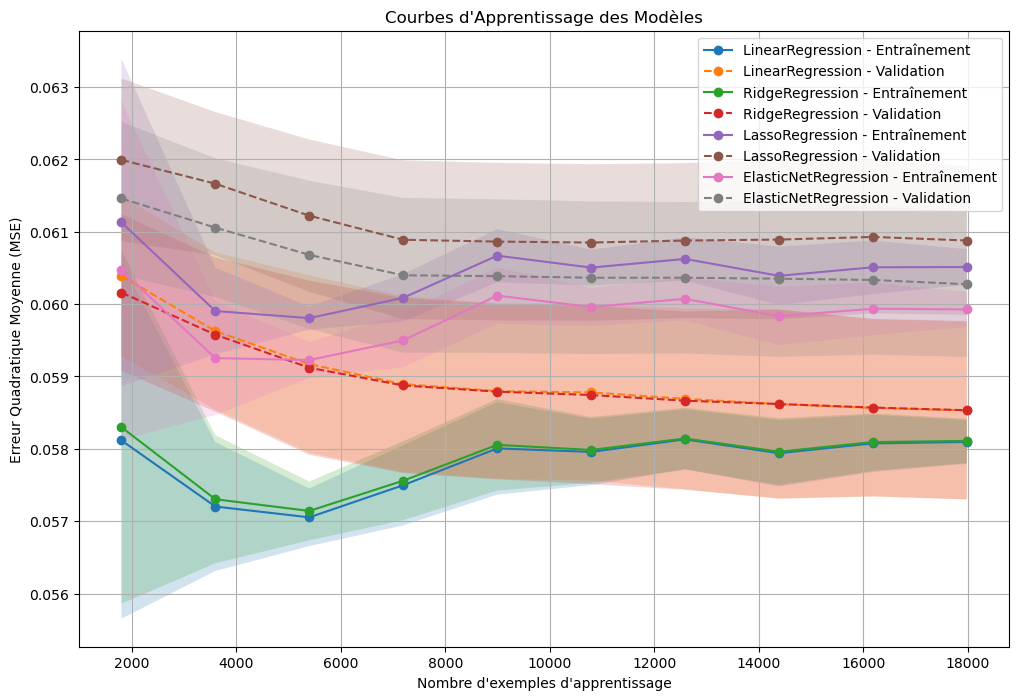

In [149]:
train_sizes = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )
    
    # Moyenne et écart-type des scores d'apprentissage et de validation
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Tracer la courbe d'apprentissage pour chaque modèle
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f'{model_name} - Entraînement')
    plt.plot(train_sizes, test_scores_mean, 'o--', label=f'{model_name} - Validation')

    # Afficher l'intervalle de confiance
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2)

# Personnalisation du graphique
plt.xlabel("Nombre d'exemples d'apprentissage")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'Apprentissage des Modèles")
plt.legend(loc="best")
plt.grid()
plt.show()

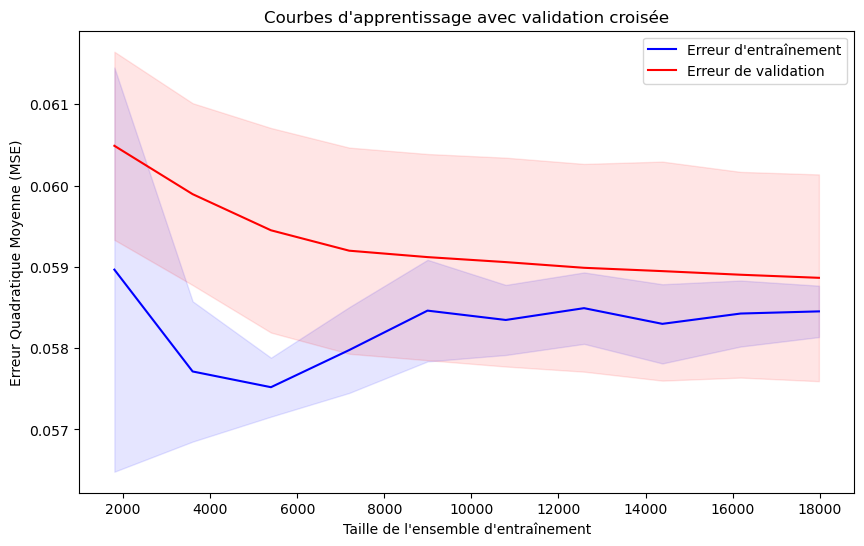

In [23]:
train_sizes, train_scores, val_scores = learning_curve(
  models['RidgeRegression']  , X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcul de la moyenne et de l'écart-type des erreurs d'entraînement et de validation
train_errors_mean = -train_scores.mean(axis=1)
train_errors_std = train_scores.std(axis=1)
val_errors_mean = -val_scores.mean(axis=1)
val_errors_std = val_scores.std(axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors_mean, label="Erreur d'entraînement", color="blue")
plt.fill_between(train_sizes, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, alpha=0.1, color="blue")
plt.plot(train_sizes, val_errors_mean, label="Erreur de validation", color="red")
plt.fill_between(train_sizes, val_errors_mean - val_errors_std, val_errors_mean + val_errors_std, alpha=0.1, color="red")

# Ajout des labels et légendes
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'apprentissage avec validation croisée")
plt.legend(loc="best")
plt.show()

* ### 2.2 Méthodes d'ensemble

In [135]:
X,y=preprocess_modeling(train_data, target_column='PrimeCommerciale_log', drop_columns=['PolicyId','AgeConducteur_log','BonusMalus_log'])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17984 entries, 8573 to 15795
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AgeVehicule_log                   17984 non-null  float64
 1   Driver_Vehicle_Age_Interaction    17984 non-null  float64
 2   Bonus_Age_Difference              17984 non-null  float64
 3   AgeConducteur_Binned_Senior       17984 non-null  float64
 4   AgeConducteur_Binned_Young        17984 non-null  float64
 5   AgeConducteur_log^2               17984 non-null  float64
 6   AgeConducteur_log BonusMalus_log  17984 non-null  float64
 7   BonusMalus_log^2                  17984 non-null  float64
 8   SexeConducteur_M                  17984 non-null  float64
 9   StatutMatrimonial_Divorced        17984 non-null  float64
 10  StatutMatrimonial_Married         17984 non-null  float64
 11  StatutMatrimonial_Non spécifié    17984 non-null  float64
 12  Statut

In [21]:
models_en=config["models"]["ensemble_methods"]
models_en

{'Random Forest': {'n_estimators': 300,
  'max_depth': 5,
  'min_samples_split': 5,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'bootstrap': True},
 'Gradient Boosting': {'n_estimators': 200,
  'learning_rate': 0.001,
  'max_depth': 5,
  'subsample': 0.8,
  'min_samples_split': 5,
  'min_samples_leaf': 2},
 'XGBoost': {'n_estimators': 300,
  'learning_rate': 0.01,
  'max_depth': 5,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'reg_lambda': 0.8,
  'reg_alpha': 0.4,
  'gamma': 0.1},
 'LightGBM': {'num_leaves': 31,
  'learning_rate': 0.05,
  'n_estimators': 300,
  'max_depth': 5,
  'subsample': 0.8,
  'colsample_bytree': 0.8,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'lambda_l1': 1.5,
  'lambda_l2': 0.8},
 'CatBoost': {'iterations': 300,
  'learning_rate': 0.05,
  'depth': 5,
  'l2_leaf_reg': 3.0,
  'subsample': 0.8,
  'bagging_temperature': 1,
  'random_strength': 1,
  'rsm': 0.8,
  'early_stopping_rounds': 50,
  'max_leaves': 31,
  'grow_policy': 'SymmetricT

In [35]:
train_data.head()

PolicyId SexeConducteur StatutMatrimonial FrequencePaiement  \
0  90144365.100b              M      Non spécifié       Half-yearly   
1  90194873.100a              M      Non spécifié            Annual   
2  90134157.100a              M      Non spécifié       Half-yearly   
3  90109178.102a              M        Cohabiting            Annual   
4  90170847.100a              M      Non spécifié            Annual   

     CodeProfession ClasseVehicule PuissanceVehicule CarburantVehicule  \
0      Non spécifié        Cheaper               P12            Diesel   
1      Non spécifié          Cheap               P12            Diesel   
2      Non spécifié        Cheaper               P10            Diesel   
3  Private employee       Cheapest                P7           Regular   
4      Non spécifié          Cheap               P13           Regular   

            UsageVehicule                     Garage  ...  \
0  Private+trip to office                Closed zbox  ...   
1            Professional                Closed zbox  ...   
2  Private+trip to office                Closed zbox  ...   
3  Private+trip to office                Closed zbox  ...   
4  Private+trip to office  Closed collective parking  ...   

  PrimeCommerciale_log  Driver_Vehicle_Age_Interaction  Bonus_Age_Difference  \
0             5.860786                        7.226278              0.218254   
1             6.273254                        4.229819              0.081678   
2             4.985659                        8.722551              0.294239   
3             5.368776                        7.079678             -0.019418   
4             5.694405                        8.155715              0.993252   

   AgeConducteur_Binned_Senior  AgeConducteur_Binned_Young  AgeConducteur_log  \
0                          0.0                         0.0           3.713572   
1                          0.0                         0.0           3.850148   
2                          0.0                         0.0           3.637586   
3                          1.0                         0.0           3.951244   
4                          0.0                         0.0           3.401197   

   BonusMalus_log  AgeConducteur_log^2  AgeConducteur_log BonusMalus_log  \
0        3.931826            13.790617                         14.601118   
1        3.931826            14.823637                         15.138109   
2        3.931826            13.232033                         14.302355   
3        3.931826            15.612327                         15.535601   
4        4.394449            11.568144                         14.946389   

   BonusMalus_log^2  
0         15.459253  
1         15.459253  
2         15.459253  
3         15.459253  
4         19.311183  

[5 rows x 24 columns]

In [22]:
models = {}
model_classes = {
    "Random Forest": RandomForestRegressor,
    "Gradient Boosting": GradientBoostingRegressor,
    "XGBoost": XGBRegressor,
    "LightGBM": LGBMRegressor,
    "CatBoost": CatBoostRegressor
}

# Dictionary to store initialized models

# Extract models from the configuration and initialize them with parameters
for model_name, parameters in models_en.items():
    model_class = model_classes.get(model_name)  # Retrieve model class
    if model_class:
        models[model_name] = model_class(**parameters)  # Initialize and store the model

# Display initialized models for verification
for name, model in models.items():
    print(f"{name}: {model}")


Random Forest: RandomForestRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=300)
Gradient Boosting: GradientBoostingRegressor(learning_rate=0.001, max_depth=5, min_samples_leaf=2,
                          min_samples_split=5, n_estimators=200, subsample=0.8)
XGBoost: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator

In [23]:
results = {
    'Model': [],
    'Mean MSE': [],
    'Mean R2': [],
    'Mean MAE':[]
}

for name, model in models.items():
    scores = evaluation_metrics(model, X_train, y_train, cv=cv)
    results['Model'].append(name)
    results['Mean MSE'].append(scores['Mean MSE'])
    results['Mean R2'].append(scores['Mean R2'])
    results['Mean MAE'].append(scores['Mean MAE'])
    


results_df = pd.DataFrame(results)
print("Évaluation des Modèles avec Validation Croisée")
print(results_df)



[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 979
[LightGBM] [Info] Number of data points in the train set: 14387, number of used features: 49
[LightGBM] [Info] Start training from score 5.916625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

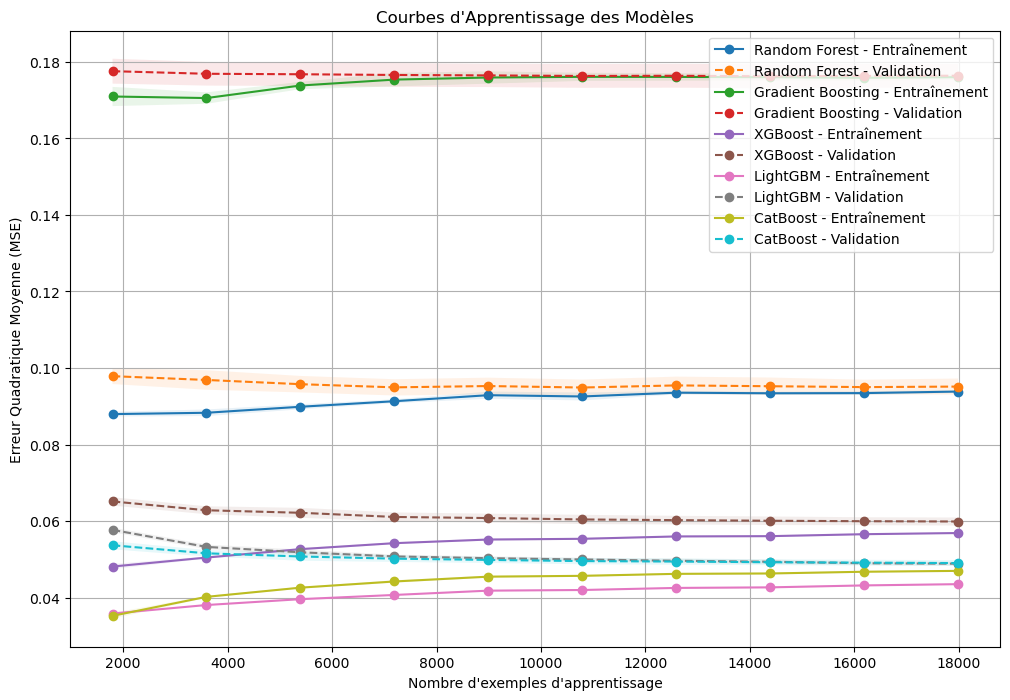

In [24]:
train_sizes = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(12, 8))

for model_name, model in models.items():
    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )
    
    # Moyenne et écart-type des scores d'apprentissage et de validation
    train_scores_mean = -train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    # Tracer la courbe d'apprentissage pour chaque modèle
    plt.plot(train_sizes, train_scores_mean, 'o-', label=f'{model_name} - Entraînement')
    plt.plot(train_sizes, test_scores_mean, 'o--', label=f'{model_name} - Validation')

    # Afficher l'intervalle de confiance
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)

# Personnalisation du graphique
plt.xlabel("Nombre d'exemples d'apprentissage")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'Apprentissage des Modèles")
plt.legend(loc="best")
plt.grid()
plt.show()

0:	learn: 0.4645779	total: 4.9ms	remaining: 1.47s
1:	learn: 0.4520087	total: 8.83ms	remaining: 1.31s
2:	learn: 0.4403745	total: 13ms	remaining: 1.29s
3:	learn: 0.4288108	total: 17.8ms	remaining: 1.31s
4:	learn: 0.4184364	total: 21.5ms	remaining: 1.27s
5:	learn: 0.4093264	total: 25.5ms	remaining: 1.25s
6:	learn: 0.3998148	total: 30ms	remaining: 1.25s
7:	learn: 0.3912686	total: 34.2ms	remaining: 1.25s
8:	learn: 0.3851472	total: 39.1ms	remaining: 1.26s
9:	learn: 0.3784850	total: 43.5ms	remaining: 1.26s
10:	learn: 0.3706216	total: 47.9ms	remaining: 1.26s
11:	learn: 0.3642832	total: 52ms	remaining: 1.25s
12:	learn: 0.3586366	total: 55.3ms	remaining: 1.22s
13:	learn: 0.3529718	total: 60.2ms	remaining: 1.23s
14:	learn: 0.3475183	total: 63.8ms	remaining: 1.21s
15:	learn: 0.3421367	total: 73ms	remaining: 1.29s
16:	learn: 0.3380395	total: 77.2ms	remaining: 1.28s
17:	learn: 0.3341093	total: 80.5ms	remaining: 1.26s
18:	learn: 0.3297763	total: 83.5ms	remaining: 1.23s
19:	learn: 0.3257676	total: 86.

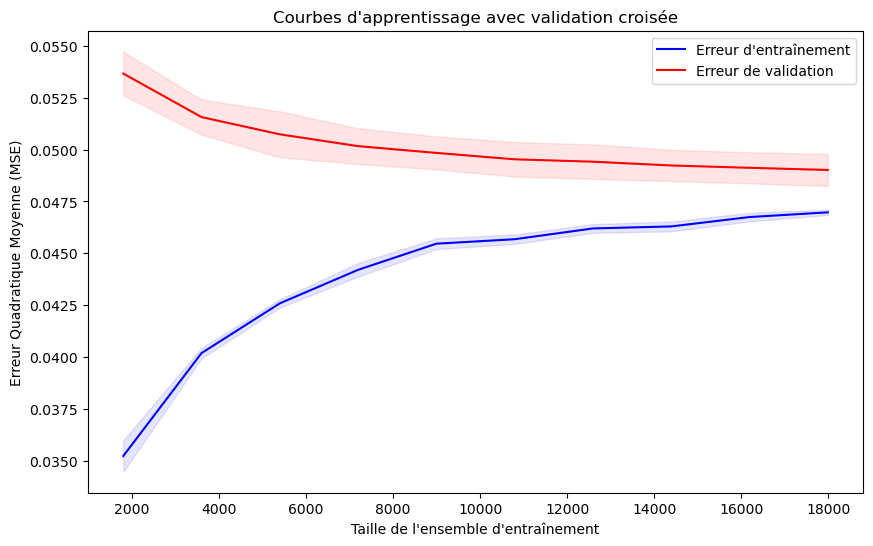

In [25]:
train_sizes, train_scores, val_scores = learning_curve(
models['CatBoost']  , X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
# Calcul de la moyenne et de l'écart-type des erreurs d'entraînement et de validation
train_errors_mean = -train_scores.mean(axis=1)
train_errors_std = train_scores.std(axis=1)
val_errors_mean = -val_scores.mean(axis=1)
val_errors_std = val_scores.std(axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors_mean, label="Erreur d'entraînement", color="blue")
plt.fill_between(train_sizes, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, alpha=0.1, color="blue")
plt.plot(train_sizes, val_errors_mean, label="Erreur de validation", color="red")
plt.fill_between(train_sizes, val_errors_mean - val_errors_std, val_errors_mean + val_errors_std, alpha=0.1, color="red")

# Ajout des labels et légendes
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'apprentissage avec validation croisée")
plt.legend(loc="best")
plt.show()

[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5
[LightGBM] [Warning] lambda_l2 is set=0.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 943
[LightGBM] [Info] Number of data points in the train set: 1798, number of used features: 43
[LightGBM] [Info] Start training from score 5.906791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

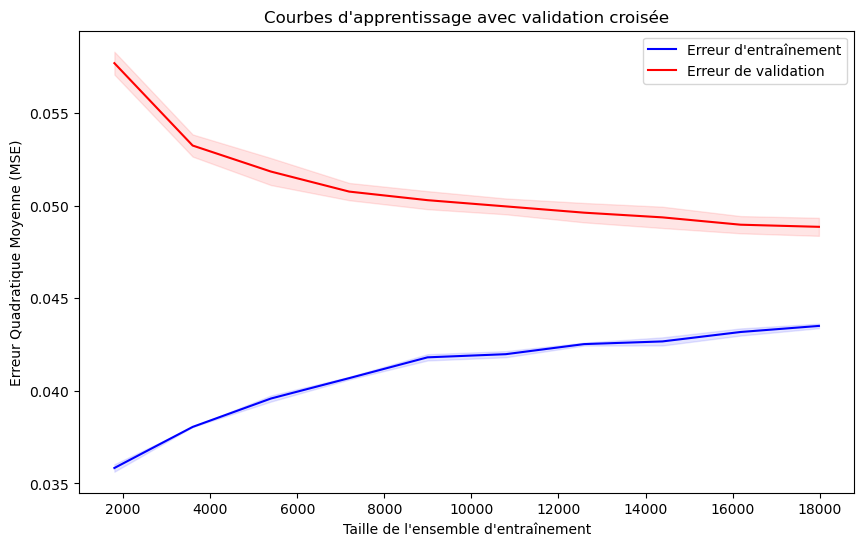

In [27]:
train_sizes, train_scores, val_scores = learning_curve(
models['LightGBM']  , X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10)
)
# Calcul de la moyenne et de l'écart-type des erreurs d'entraînement et de validation
train_errors_mean = -train_scores.mean(axis=1)
train_errors_std = train_scores.std(axis=1)
val_errors_mean = -val_scores.mean(axis=1)
val_errors_std = val_scores.std(axis=1)

# Tracé des courbes d'apprentissage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors_mean, label="Erreur d'entraînement", color="blue")
plt.fill_between(train_sizes, train_errors_mean - train_errors_std, train_errors_mean + train_errors_std, alpha=0.1, color="blue")
plt.plot(train_sizes, val_errors_mean, label="Erreur de validation", color="red")
plt.fill_between(train_sizes, val_errors_mean - val_errors_std, val_errors_mean + val_errors_std, alpha=0.1, color="red")

# Ajout des labels et légendes
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'apprentissage avec validation croisée")
plt.legend(loc="best")
plt.show()

* ### 2.3 NeuralNetwork MLP

In [ ]:
Mlp_model=config['models']['neural_networks']
Mlp_model['MLP']

{'hidden_layer_sizes': [150, 100, 50],
 'max_iter': 100000,
 'alpha': 0.5,
 'learning_rate': 'adaptive',
 'learning_rate_init': 1e-05,
 'validation_fraction': 0.2,
 'activation': 'tanh',
 'early_stopping': True,
 'solver': 'adam'}

In [44]:
Mlp_model['MLP']=MLPRegressor(**Mlp_model['MLP'])

In [45]:

results = {
    'Model': [],
    'Mean MSE': [],
    'Mean R2': [],
    'Mean MAE':[]
}

for name, model in Mlp_model.items():
    scores = evaluation_metrics(model, X_train, y_train, cv=cv)
    results['Model'].append(name)
    results['Mean MSE'].append(scores['Mean MSE'])
    results['Mean R2'].append(scores['Mean R2'])
    results['Mean MAE'].append(scores['Mean MAE'])
    


results_df = pd.DataFrame(results)
print("Évaluation des Modèles avec Validation Croisée")
print(results_df)

Évaluation des Modèles avec Validation Croisée
  Model  Mean MSE   Mean R2  Mean MAE
0   MLP  0.052513  0.766412  0.180309


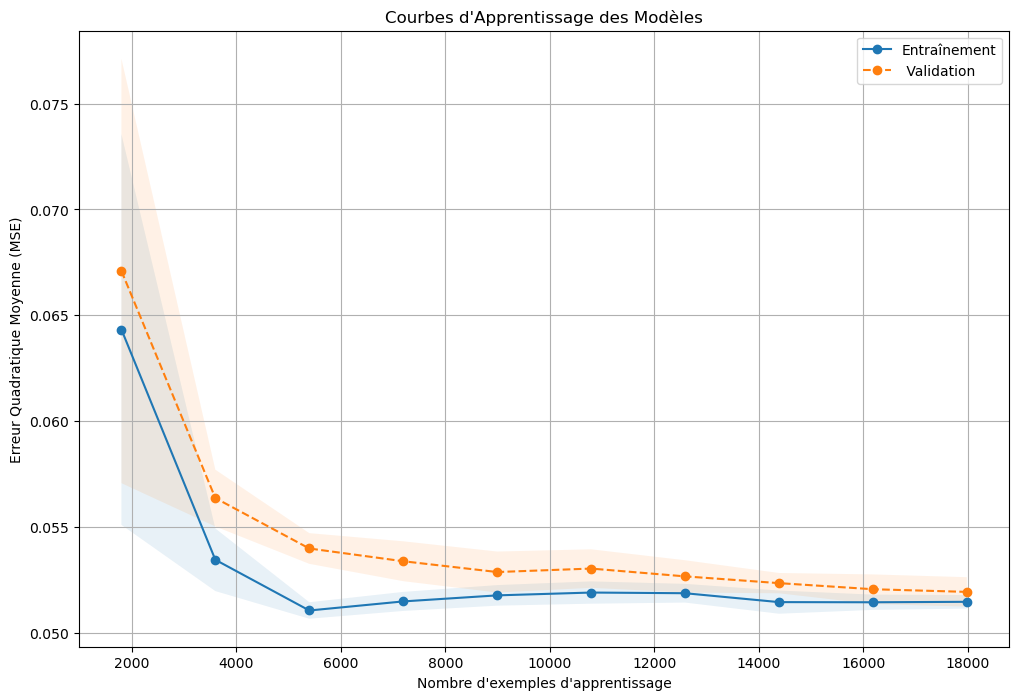

In [46]:
train_sizes = np.linspace(0.1, 1.0, 10)
plt.figure(figsize=(12, 8))

    # Calcul des courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )
    
    # Moyenne et écart-type des scores d'apprentissage et de validation
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

    # Tracer la courbe d'apprentissage pour chaque modèle
plt.plot(train_sizes, train_scores_mean, 'o-', label= 'Entraînement')
plt.plot(train_sizes, test_scores_mean, 'o--', label=' Validation')

    # Afficher l'intervalle de confiance
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)

# Personnalisation du graphique
plt.xlabel("Nombre d'exemples d'apprentissage")
plt.ylabel("Erreur Quadratique Moyenne (MSE)")
plt.title("Courbes d'Apprentissage des Modèles")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [47]:
Model=Mlp_model['MLP'].fit(X_train,y_train)
y_pred=Model.predict(X_val)
print('Validation on set :',evaluate_on_validation_set(Model,y_val,y_pred))

Validation on set : {'Validation MSE': 0.0505001259637555, 'Validation R2': 0.772597033500434, 'Validation MAE': 0.17613052006031765, 'Validation RMSE': 0.22472233080794507}


Après une comparaison des modèles, le modèle Mlpregressor a démontré une performance supérieure grâce à un ajustement optimisé des hyperparamètres et à l'application de techniques efficaces pour limiter le surapprentissage (overfitting)."

### 3. Anlayse des Résidus

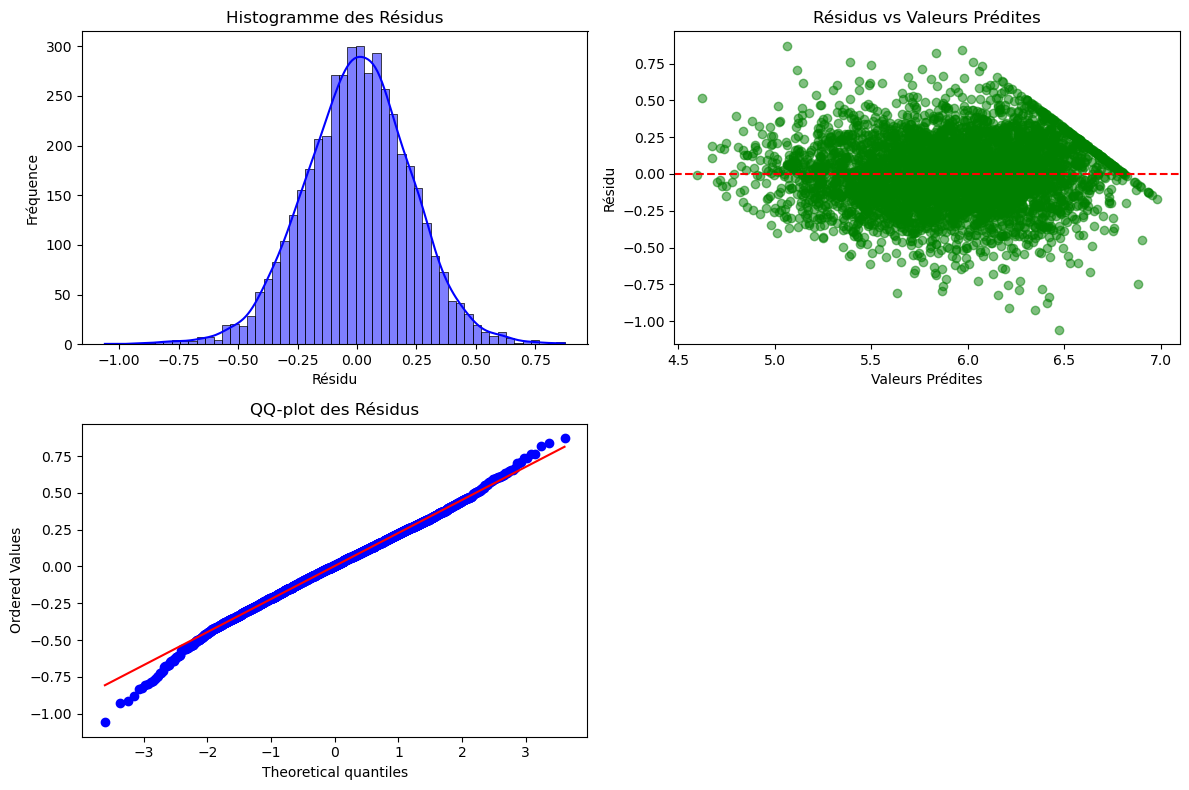

In [48]:
import scipy.stats as stats
residuals = y_val - y_pred


# 1. Histogramme des résidus
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(residuals, kde=True, color="blue")
plt.title("Histogramme des Résidus")
plt.xlabel("Résidu")
plt.ylabel("Fréquence")

# 2. Graphique des résidus vs valeurs prédites
plt.subplot(2, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.5, color="green")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Résidus vs Valeurs Prédites")
plt.xlabel("Valeurs Prédites")
plt.ylabel("Résidu")

# 3. QQ-plot pour la normalité des résidus
plt.subplot(2, 2, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot des Résidus")

# Afficher les graphiques
plt.tight_layout()
plt.show()


* Les résidus suivent une distribution normale, centrée autour de 0, indiquant que les erreurs sont bien réparties.

* Pour les Résidus vs Valeurs Prédictes : Pas de structure évidente, confirmant une bonne homogénéité des erreurs. Cependant, une légère dispersion est visible pour des valeurs prédites élevées.

* QQ-plot : Les résidus suivent globalement la ligne théorique, suggérant une normalité acceptable avec de légères déviations aux extrêmes.

En conclusion, le modèle est bien ajusté, avec des erreurs raisonnablement réparties et peu de biais visibles.

### 4. Sauvegarde du Modèle avec Chemin Configuré

In [71]:
model_dir=config['data']['model_save_path']  
save_model_with_directory(Model,model_dir,'Model.pkl')

Modèle sauvegardé avec succès dans models/Model.pkl


# Étape 3 :Exportation des prédictions :



In [53]:
test_data.head()

PolicyId  AgeConducteur SexeConducteur StatutMatrimonial  BonusMalus  \
0  90161646.100a             48              M               NaN        50.0   
1  90146211.102b             23              M               NaN        95.0   
2  90168719.100a             45              M               NaN        50.0   
3  90132211.100a             27              M               NaN        95.0   
4    1000755.10a             30              M            Single        62.0   

  FrequencePaiement    CodeProfession  AgeVehicule ClasseVehicule  \
0            Annual               NaN            1     Medium low   
1            Annual               NaN           28       Cheapest   
2            Annual               NaN           19          Cheap   
3       Half-yearly               NaN            1          Cheap   
4       Half-yearly  Private employee           10        Cheaper   

  PuissanceVehicule CarburantVehicule           UsageVehicule  \
0               P13            Diesel  Private+trip to office   
1               P10           Regular  Private+trip to office   
2               P10            Diesel  Private+trip to office   
3               P13            Diesel  Private+trip to office   
4               P12            Diesel  Private+trip to office   

                      Garage        Region  
0                Closed zbox    Paris area  
1                     Street        Center  
2  Opened collective parking  Headquarters  
3                Closed zbox        Center  
4  Opened collective parking  Headquarters

In [54]:
preprocess_data_test=preprocess_data(test_data) # Data with new vlaues
preprocess_data_test.head()

PolicyId  AgeConducteur SexeConducteur StatutMatrimonial  BonusMalus  \
0  90161646.100a             48              M      Non spécifié        50.0   
1  90146211.102b             23              M      Non spécifié        95.0   
2  90168719.100a             45              M      Non spécifié        50.0   
3  90132211.100a             27              M      Non spécifié        95.0   
4    1000755.10a             30              M            Single        62.0   

  FrequencePaiement    CodeProfession  AgeVehicule ClasseVehicule  \
0            Annual      Non spécifié            1     Medium low   
1            Annual      Non spécifié           28       Cheapest   
2            Annual      Non spécifié           19          Cheap   
3       Half-yearly      Non spécifié            1          Cheap   
4       Half-yearly  Private employee           10        Cheaper   

  PuissanceVehicule CarburantVehicule           UsageVehicule  \
0               P13            Diesel  Private+trip to office   
1               P10           Regular  Private+trip to office   
2               P10            Diesel  Private+trip to office   
3               P13            Diesel  Private+trip to office   
4               P12            Diesel  Private+trip to office   

                      Garage        Region  
0                Closed zbox    Paris area  
1                     Street        Center  
2  Opened collective parking  Headquarters  
3                Closed zbox        Center  
4  Opened collective parking  Headquarters

In [ ]:
# smae data preprocessing 
test_data_pre=preprocess_data_test.copy()
columns_do_capping = config['features']['capping'][:-1]
scaled_columns = config['features']['scaled'][:-1]
for col in columns_do_capping:
    test_data_pre = cap_outliers(test_data_pre, col) #Limite les valeurs extrêmes pour stabiliser les distributions.
test_data_pre=log_transform(test_data_pre,Numerical_colomuns[:-1]) #Limite les valeurs extrêmes pour stabiliser les distributions
#train_data=scale_features(train_data,scaled_columns)
test_data_pre.drop(columns=Numerical_colomuns[:-1], inplace=True) #Garde uniquement les versions transformées des colonnes.
print(test_data_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9636 entries, 0 to 9635
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PolicyId           9636 non-null   object 
 1   SexeConducteur     9636 non-null   object 
 2   StatutMatrimonial  9636 non-null   object 
 3   FrequencePaiement  9636 non-null   object 
 4   CodeProfession     9636 non-null   object 
 5   ClasseVehicule     9636 non-null   object 
 6   PuissanceVehicule  9636 non-null   object 
 7   CarburantVehicule  9636 non-null   object 
 8   UsageVehicule      9636 non-null   object 
 9   Garage             9636 non-null   object 
 10  Region             9636 non-null   object 
 11  AgeConducteur_log  9636 non-null   float64
 12  BonusMalus_log     9636 non-null   float64
 13  AgeVehicule_log    9636 non-null   float64
dtypes: float64(3), object(11)
memory usage: 1.0+ MB
None


In [56]:
test_data_pre = add_interaction_feature(test_data_pre)
test_data_pre = bin_age_conducteur(test_data_pre)
test_data_pre = create_bonus_age_difference(test_data_pre)
test_data_pre = encode_binned_age(test_data_pre)
#test_data_pre = add_polynomial_features(test_data_pre, ['AgeConducteur_log', 'BonusMalus_log'])

In [57]:
X_test=preprocess_modeling(test_data_pre,drop_columns=['PolicyId'])

In [58]:
X_test['PuissanceVehicule_P6'] = 0

In [60]:
expected_features = list(Model.feature_names_in_)

# Réorganiser les colonnes dans l’ordre attendu
X_test = X_test[expected_features]


In [61]:
assert list(X_test.columns) == list(expected_features), "Les colonnes ne sont toujours pas alignées !"

In [62]:
y_pred_log=Model.predict(X_test)

In [63]:

y_pred=np.exp(y_pred_log)

In [64]:
y_pred

array([560.55469154, 320.20723994, 179.94143939, ..., 246.67086671,
       603.98720867, 372.98983231])

In [165]:
config['data']['output_path']

'output/results.csv'

In [ ]:
Q1 = data['PrimeCommerciale'].quantile(0.25)
Q3 = data['PrimeCommerciale'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
bounds = {"lower": lower_bound, "upper": upper_bound}
y_pred = np.where(y_pred < bounds["lower"], bounds["lower"], y_pred)
y_pred = np.where(y_pred > bounds["upper"], bounds["upper"], y_pred) 

resultas=pd.DataFrame({
          "PolicyId":test_data['PolicyId'],
          "PrimeCommercialePred": y_pred
})


resultas.to_csv(config['data']['output_path'], index=False)

# Conclusion 

Résultats
- Le modèle le plus performant a été sélectionné après optimisation des hyperparamètres.
- Les métriques obtenues, comme le R² et l’erreur quadratique moyenne (RMSE), montrent une
 amélioration significative après nettoyage,l’ajout des nouvelles caractéristiques et l’optimisation.
 
Livrables
 - Un fichier CSV contenant les prédictions (PolicyId et PrimeCommercialePred) sur le jeu de données test.
 - Un notebook documentant l’ensemble des étapes, des analyses exploratoires à l’entraînement du modèle.
